In [1]:
import pandas
import time

from lib.policy_guided_explorer import Explorer

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

In [2]:
network = dict(alpha=0.33, gamma=0.33)

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


# related work baseline

add_model(
    scenario="reference",
    model="fc16sapirshtein",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    protocol="bitcoin",
    implicit_mdp=FC16Sapirshtein(**network, maximum_fork_length=999999),
)

# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_scenario(
    scenario,
    *,
    force_consider_own=False,
    merge_isomorphic=False,
    truncate_common_chain=True,
    collect_garbage=True
):
    def f(protocol_s, protocol_C, **protocol_args):
        add_model(
            scenario=scenario,
            model="generic_1",
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=truncate_common_chain,
            collect_garbage=collect_garbage,
            protocol=protocol_s,
            implicit_mdp=G1Model(
                protocol_C,
                **protocol_args,
                **network,
                force_consider_own=force_consider_own,
                merge_isomorphic=merge_isomorphic,
                collect_garbage=collect_garbage,
                truncate_common_chain=truncate_common_chain,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_scenario("baseline")
add_scenario("w/o truncate", truncate_common_chain=False)
add_scenario("w/o garbage collection", collect_garbage=False)
add_scenario("w/ force consider", force_consider_own=True)
add_scenario("w/ normalization", merge_isomorphic=True)
add_scenario("w/ both", force_consider_own=True, merge_isomorphic=True)

models = pandas.DataFrame(models)
models

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol
0,reference,fc16sapirshtein,True,True,True,True,bitcoin
1,baseline,generic_1,False,False,True,True,bitcoin
2,baseline,generic_1,False,False,True,True,ethereum_3
3,baseline,generic_1,False,False,True,True,byzantium_3
4,baseline,generic_1,False,False,True,True,ghostdag_3
5,baseline,generic_1,False,False,True,True,parallel_3
6,w/o truncate,generic_1,False,False,False,True,bitcoin
7,w/o truncate,generic_1,False,False,False,True,ethereum_3
8,w/o truncate,generic_1,False,False,False,True,byzantium_3
9,w/o truncate,generic_1,False,False,False,True,ghostdag_3


In [3]:
from IPython.display import display, clear_output

max_size = 100000
aborts = []
size_log = []

for idx, row in models.iterrows():
    m = implicit_mdps[idx]
    explorer = Explorer(m, m.honest)

    start_time = time.monotonic()
    try:
        explorer.explore_along_policy(max_states=max_size)
    except RuntimeError as e:
        if e.args == ("state size limit exceeded",):
            aborts.append(
                row.to_dict()
                | dict(
                    reason="state size limit exceeded",
                    depth=0,
                    time_spent=time.monotonic() - start_time,
                )
            )
            continue
        else:
            raise e

    depth = 0
    size_log.append(
        row.to_dict()
        | dict(
            depth=0, size=explorer.n_states, time_spent=time.monotonic() - start_time
        )
    )

    def report():
        d = size_log[-1]
        print(
            "\t".join(
                [
                    f"{k}: {d[k]}"
                    for k in ["scenario", "protocol", "depth", "size", "time_spent"]
                ]
            )
        )

    report()

    while True:
        # increase depth by one
        try:
            explorer.explore_aside_policy(max_states=max_size)
            explorer.explore_along_policy(max_states=max_size)
        except RuntimeError as e:
            if e.args == ("state size limit exceeded",):
                aborts.append(
                    row.to_dict()
                    | dict(
                        reason="state size limit exceeded",
                        depth=depth + 1,
                        time_spent=time.monotonic() - start_time,
                    )
                )
                break
            else:
                raise e

        depth += 1
        size_log.append(
            row.to_dict()
            | dict(
                depth=depth,
                size=explorer.n_states,
                time_spent=time.monotonic() - start_time,
            )
        )

        report()


size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

scenario: reference	protocol: bitcoin	depth: 0	size: 3	time_spent: 0.00010135000047739595
scenario: reference	protocol: bitcoin	depth: 1	size: 7	time_spent: 0.00036019600156578235
scenario: reference	protocol: bitcoin	depth: 2	size: 14	time_spent: 0.00063874800252961
scenario: reference	protocol: bitcoin	depth: 3	size: 23	time_spent: 0.0009264479995181318
scenario: reference	protocol: bitcoin	depth: 4	size: 35	time_spent: 0.0012549740022222977
scenario: reference	protocol: bitcoin	depth: 5	size: 49	time_spent: 0.0016870239996933378
scenario: reference	protocol: bitcoin	depth: 6	size: 66	time_spent: 0.0022129909993964247
scenario: reference	protocol: bitcoin	depth: 7	size: 85	time_spent: 0.002803949002554873
scenario: reference	protocol: bitcoin	depth: 8	size: 107	time_spent: 0.0034654900009627454
scenario: reference	protocol: bitcoin	depth: 9	size: 131	time_spent: 0.0042262370006938
scenario: reference	protocol: bitcoin	depth: 10	size: 158	time_spent: 0.005047296999691753
scenario: ref

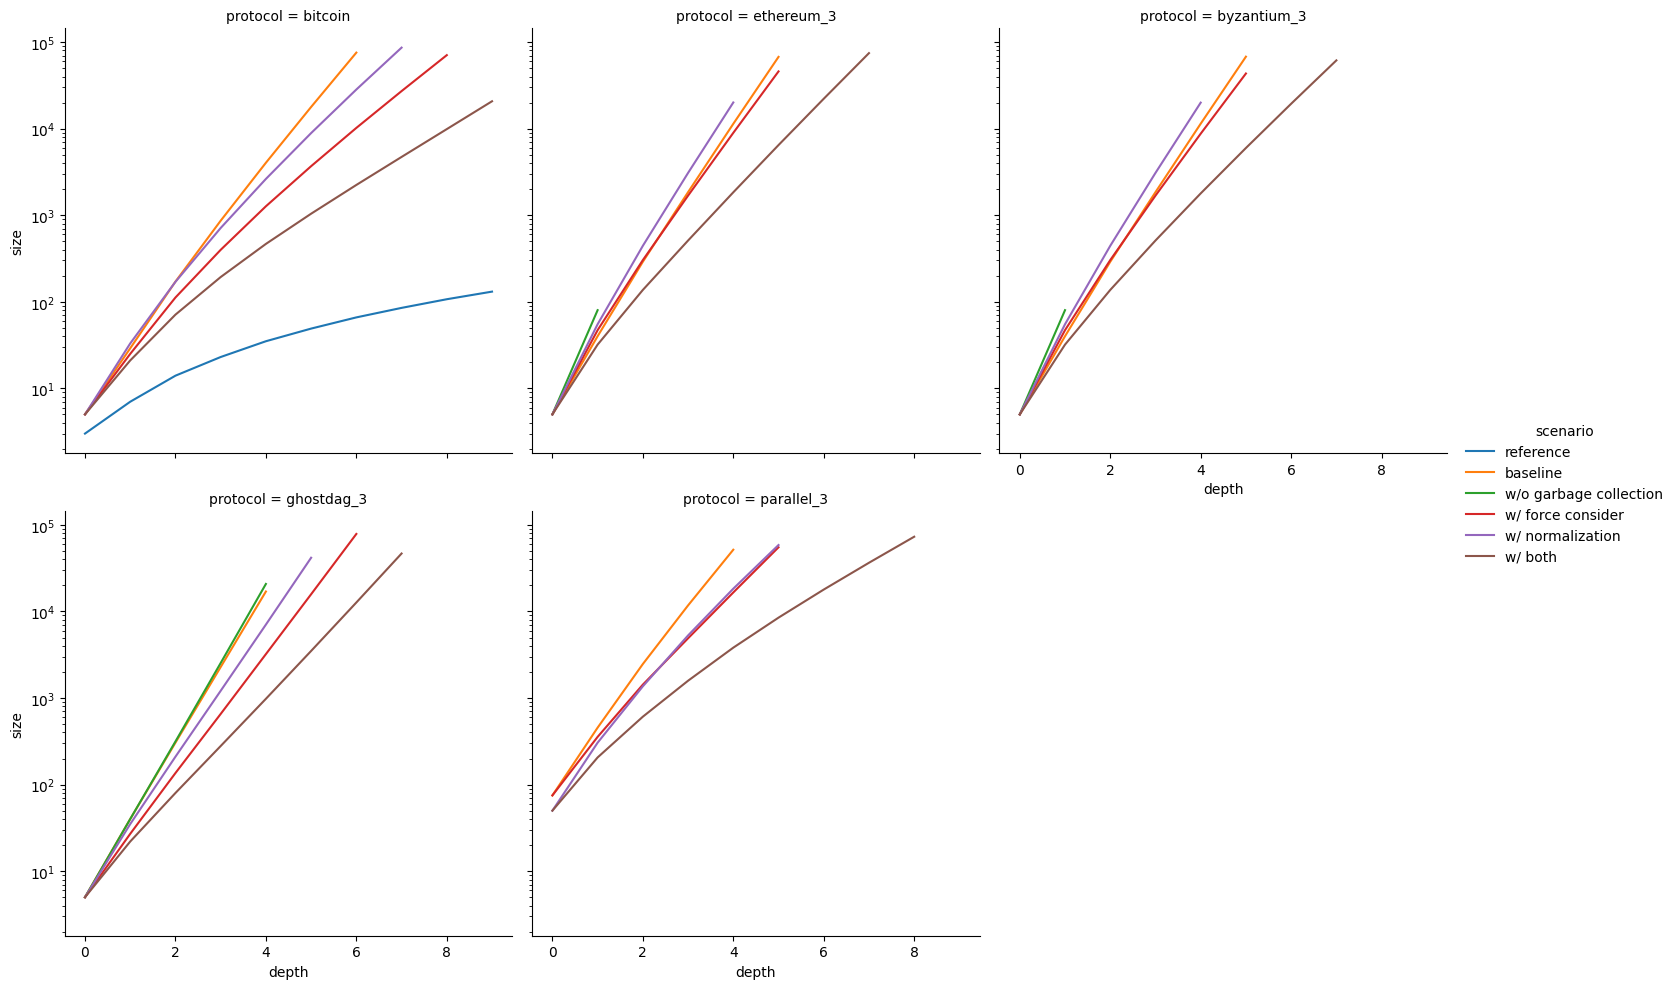

In [4]:
import seaborn

seaborn.relplot(
    data=size_log.query("depth < 10"),
    kind="line",
    x="depth",
    y="size",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")

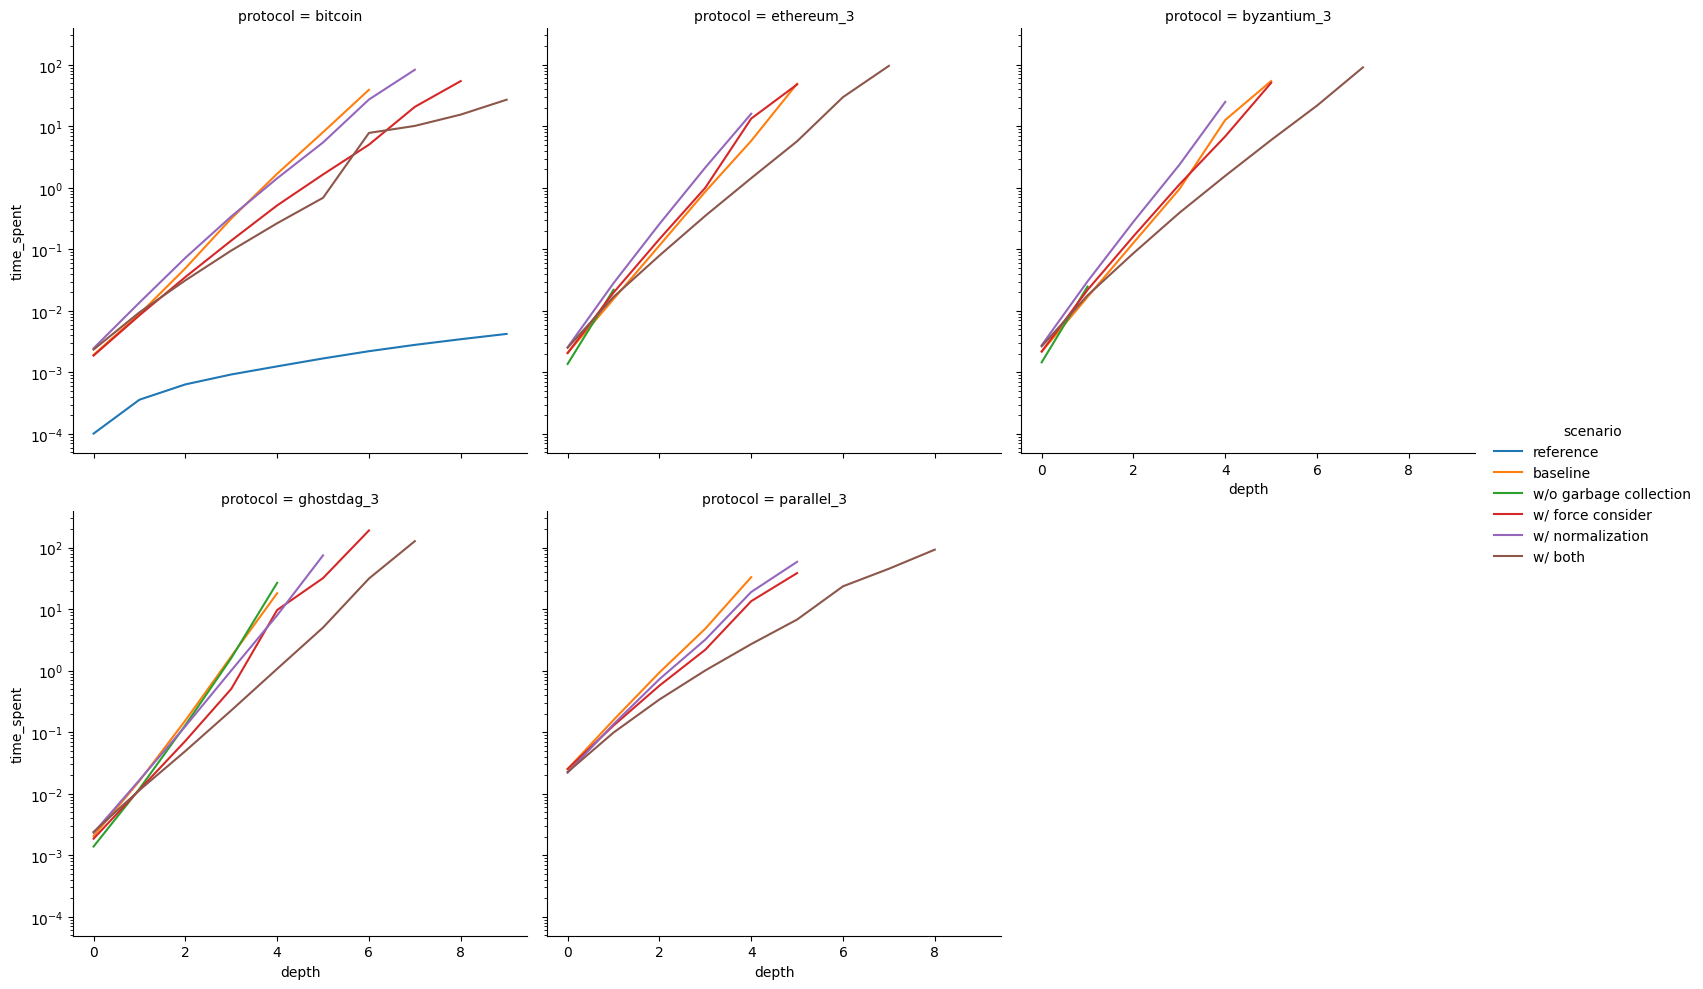

In [5]:
import seaborn

seaborn.relplot(
    data=size_log.query("depth < 10"),
    kind="line",
    x="depth",
    y="time_spent",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")

In [9]:
sum(aborts.time_spent) / 60  # minutes

50.33702061256663

In [11]:
aborts.to_pickle("4-state-space-exploration-for-paper-aborts.pkl.gz")
size_log.to_pickle("4-state-space-exploration-for-paper-size_log.pkl.gz")